<h2>Imports</h2>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time


In [9]:
!wget http://www.zemris.fer.hr/~kalfa/Datasets/rMASTIF/rmastif_test.tar.gz
!wget http://www.zemris.fer.hr/~kalfa/Datasets/rMASTIF/rmastif_train.tar.gz
!mkdir Training
!mkdir Testing
!tar -xvf /content/rmastif_test.tar.gz -C /content/Testing
!tar -xvf /content/rmastif_train.tar.gz -C /content/Training

Streaming output truncated to the last 5000 lines.
00015/00021_00000.ppm
00015/00000_00003.ppm
00015/00031_00001.ppm
00015/00015_00001.ppm
00015/00028_00003.ppm
00015/00004_00003.ppm
00015/00014_00003.ppm
00015/00011_00001.ppm
00015/00012_00001.ppm
00015/00031_00002.ppm
00015/00026_00002.ppm
00015/00029_00002.ppm
00015/00007_00003.ppm
00015/00016_00001.ppm
00015/00019_00003.ppm
00015/00000_00000.ppm
00015/00005_00002.ppm
00015/00002_00000.ppm
00015/00003_00002.ppm
00015/00003_00001.ppm
00015/00009_00000.ppm
00015/00018_00000.ppm
00015/00031_00000.ppm
00015/00013_00000.ppm
00015/00015_00002.ppm
00015/00006_00003.ppm
00015/00021_00001.ppm
00015/00020_00003.ppm
00015/00006_00001.ppm
00015/00014_00002.ppm
00015/00025_00001.ppm
00015/00000_00002.ppm
00016/
00016/00016_00000.ppm
00016/00025_00003.ppm
00016/00004_00000.ppm
00016/00006_00000.ppm
00016/00029_00001.ppm
00016/00005_00001.ppm
00016/00014_00000.ppm
00016/00029_00003.ppm
00016/00002_00002.ppm
00016/00008_00003.ppm
00016/00023_00000.

In [5]:
def loadData(batch_size):
  test_path = '/content/Testing'
  train_path = '/content/Training'

  preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomAutocontrast(),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])


  data = torchvision.datasets.ImageFolder(root=train_path, transform=preprocess)
  train_dataLoader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True,  num_workers=2)
  print('Train',len(data))

  test_data = torchvision.datasets.ImageFolder(root=test_path,transform=preprocess)
  
  print('TEST',len(test_data))
  test_dataLoader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True,  num_workers=2)
  return train_dataLoader, test_dataLoader

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 205):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [7]:
def train(num_epochs, model, train_loader, criterion, optimizer):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("Device: {}".format(device))
  model.to(device)
  accuracies_list = []
  losses_list = []

  model.train()

  steps_length = len(train_loader)
  for epoch in range(num_epochs):
    steps=0
    correct = 0
    for i, data in enumerate(train_loader):
      images, labels = data[0].to(device), data[1].to(device)

      #Forward Pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      #Backpropogation and Optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #Train Accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data,1)

      correct = (predicted == labels).sum().item()
      steps = i + 1
    accuracy = (correct / total) * 100
    accuracies_list.append(accuracy)
    losses_list.append(loss.item())
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
      .format(epoch + 1, num_epochs, i + 1, steps_length, loss.item(),
          accuracy))
        
  return accuracies_list, losses_list, model
      
    

# Optimization using Grid Search
Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. It is an exhaustive search that is performed on a the specific parameter values of a model.
## 1) Learning rate
Perform a grid search over learning rate. Use learning rate = {0.01,0.001,0.0001}.  

1.   Define a dictionary "hyper_parameters" with the key "learning_rate". The key takes as value 0.01, 0.001, and 0.0001. 
2.   Define a dictionary "train_loss_hyper_paramaters", and set the keys to "lr0.01", "lr0.001", and "lr0.0001". The key takes as values the train loss to each learning rate.
3.   Define another dictionary "train_acc_hyper_paramaters", and set the keys to "lr0.01", "lr0.001", and "lr0.0001". The key takes as values the train accuracy to each learning rate.
4.   Set optimizer to Adam, number of epochs to 20, batch size to 32, and loss function to cross entorpy.
5.   Define a for loop to iterate over every learning rate value. In the for loop, define a model from the previously defined CNN architecure, the criterion, and the optimizer. After that, load the dataset from cifar_loader, read the "train" funciton written earlier. Finally, just store the train loss and accuracy for each learning rate in two different dictionaries, "train_loss_hyper_paramaters", and "train_acc_hyper_paramaters". 

In [10]:
############ Define the dictionaries and set the values for number of epochs and batch size ############
hyper_parameters = {'learning_rate': [0.01,0.001,0.0001]}
train_loss_hyper_paramaters= {'lr0.01':None, 'lr0.001':None, 'lr0.0001':None}
train_acc_hyper_paramaters= {'lr0.01':None, 'lr0.001':None, 'lr0.0001':None}

for learning_rate in hyper_parameters["learning_rate"]:
    print(f'Results of the learning rate = {learning_rate}')
    ######## Write your code here ##############
    ############ Define model, criterion, and optimizer here ############
    model = ResNet(ResidualBlock, [3, 4, 6, 3],31)
    #model.eval()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epochs= 30

    ############ Load cifar-10 dataset ###########
    train_loader, test_loader = loadData(32)

    ############ Call the train function ###########
    
    train_accuracy, train_loss, model = train(epochs, model, train_loader, criterion, optimizer)

    ############ Store train_loss, and train_accuracy in the defined dictionaries ###########
    train_loss_hyper_paramaters[f"lr{learning_rate}"]= train_loss
    train_acc_hyper_paramaters[f"lr{learning_rate}"]= train_accuracy



Results of the learning rate = 0.01
Train 4044
TEST 1784
Device: cuda:0
Epoch [1/30], Step [127/127], Loss: 3.2378, Accuracy: 16.67%
Epoch [2/30], Step [127/127], Loss: 1.9138, Accuracy: 58.33%
Epoch [3/30], Step [127/127], Loss: 2.5327, Accuracy: 25.00%
Epoch [4/30], Step [127/127], Loss: 1.4794, Accuracy: 58.33%
Epoch [5/30], Step [127/127], Loss: 1.1710, Accuracy: 50.00%
Epoch [6/30], Step [127/127], Loss: 1.8337, Accuracy: 41.67%
Epoch [7/30], Step [127/127], Loss: 0.9520, Accuracy: 66.67%
Epoch [8/30], Step [127/127], Loss: 0.7729, Accuracy: 66.67%
Epoch [9/30], Step [127/127], Loss: 0.5201, Accuracy: 83.33%
Epoch [10/30], Step [127/127], Loss: 1.7309, Accuracy: 58.33%
Epoch [11/30], Step [127/127], Loss: 0.1607, Accuracy: 91.67%
Epoch [12/30], Step [127/127], Loss: 0.4198, Accuracy: 91.67%
Epoch [13/30], Step [127/127], Loss: 0.7007, Accuracy: 75.00%
Epoch [14/30], Step [127/127], Loss: 0.9686, Accuracy: 66.67%
Epoch [15/30], Step [127/127], Loss: 0.4500, Accuracy: 75.00%
Epoch [

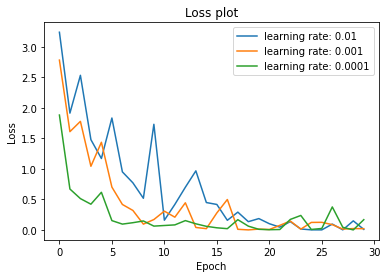

In [11]:
####### plot the the training loss here #########

num_epochs = 30
epochs = [x for x in range(num_epochs)]
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss plot")

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(
        epochs,
        train_loss_hyper_paramaters[f"lr{learning_rate}"],
        label=f"learning rate: {learning_rate}",
    )


plt.legend()

Plot the train accuracy versus epoch for each learning rate in one plot. Use legends to differentiate between the plots (3 diagrams in one plot).  

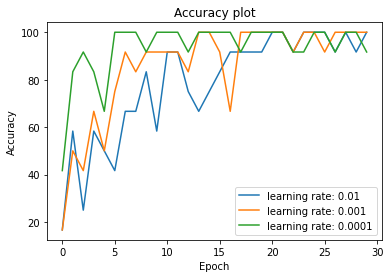

In [12]:
####### plot the the training accuracies here #########

epochs = [x for x in range(num_epochs)]
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(
        epochs,
        train_acc_hyper_paramaters[f"lr{learning_rate}"],
        label=f"learning rate: {learning_rate}",
    )

plt.legend()


# Batch Size
Perform a grid search over learning rate. Use batch size = {32, 64, 128}.  

1.   Defining a dictionary "hyper_parameters" with the key "batch_size". The key takes as value 32, 64, and 128. 
2.   Defining a dictionary "train_loss_hyper_paramaters", and set the keys to "b32", "b64", and "b128". The key takes as values the train loss to each learning rate.
3.   Defining another dictionary "train_acc_hyper_paramaters", and set the keys to "b32", "b64", and "b128". The key takes as values the train accuracy to each learning rate.
4.   Set optimizer to Adam, number of epochs to 20, learning rate to 0.001, and loss function to cross entorpy.
5.   Defining the for loop in the same way as the last time.

In [14]:
######## Write your code here ##############
############### Write your code here ##############
############ Defining the dictionaries and set the values for number of epochs and batch size ############
hyper_parameters = {"batch_size": [32, 64, 128]}
train_loss_hyper_paramaters = {"b32": None, "b64": None, "b128": None}
train_acc_hyper_paramaters = {"b32": None, "b64": None, "b128": None}
learning_rate = 0.001
epochs = 20

for batch_size in hyper_parameters["batch_size"]:
    print(f"Results of the batch size = {batch_size}")
    ######## Write your code here ##############
    ############ Defining model, criterion, and optimizer here ############
    model = ResNet(ResidualBlock, [3, 4, 6, 3],31)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ############ Load cifar-10 dataset ###########
    train_loader, test_loader = loadData(batch_size)

    ############ Call the train function ###########
    train_accuracy, train_loss, model = train(
        epochs, model, train_loader, criterion, optimizer
    )

    ############ Store train_loss, and train_accuracy in the defined dictionaries ###########
    train_loss_hyper_paramaters[f"b{batch_size}"] = train_loss
    train_acc_hyper_paramaters[f"b{batch_size}"] = train_accuracy


Results of the batch size = 32
Train 4044
TEST 1784
Device: cuda:0
Epoch [1/20], Step [127/127], Loss: 2.1707, Accuracy: 33.33%
Epoch [2/20], Step [127/127], Loss: 2.7713, Accuracy: 33.33%
Epoch [3/20], Step [127/127], Loss: 1.6966, Accuracy: 50.00%
Epoch [4/20], Step [127/127], Loss: 0.7333, Accuracy: 75.00%
Epoch [5/20], Step [127/127], Loss: 1.3452, Accuracy: 50.00%
Epoch [6/20], Step [127/127], Loss: 0.4921, Accuracy: 75.00%
Epoch [7/20], Step [127/127], Loss: 0.5726, Accuracy: 83.33%
Epoch [8/20], Step [127/127], Loss: 0.5134, Accuracy: 75.00%
Epoch [9/20], Step [127/127], Loss: 0.2480, Accuracy: 100.00%
Epoch [10/20], Step [127/127], Loss: 0.2324, Accuracy: 91.67%
Epoch [11/20], Step [127/127], Loss: 0.5211, Accuracy: 83.33%
Epoch [12/20], Step [127/127], Loss: 0.0155, Accuracy: 100.00%
Epoch [13/20], Step [127/127], Loss: 0.8506, Accuracy: 75.00%
Epoch [14/20], Step [127/127], Loss: 0.1018, Accuracy: 91.67%
Epoch [15/20], Step [127/127], Loss: 0.0305, Accuracy: 100.00%
Epoch [16

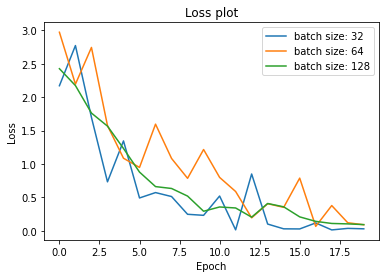

In [15]:
####### plot the the training loss here #########
num_epochs = 20
epochs = [x for x in range(num_epochs)]
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss plot")

for batch_size in hyper_parameters["batch_size"]:
    plt.plot(
        epochs,
        train_loss_hyper_paramaters[f"b{batch_size}"],
        label=f"batch size: {batch_size}",
    )

plt.legend()


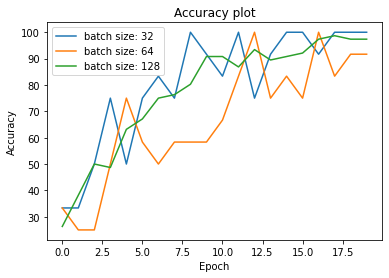

In [16]:
####### plot the the training accuracies here #########

epochs = [x for x in range(num_epochs)]
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")

for batch_size in hyper_parameters["batch_size"]:
    plt.plot(
        epochs,
        train_acc_hyper_paramaters[f"b{batch_size}"],
        label=f"batch size: {batch_size}",
    )

plt.legend()


Performing a grid search over loss function = {["neg_log_likelihood"](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), ["cross_entropy"](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)}.  

1.   Defining a dictionary "hyper_parameters" with the key "loss_function". The key takes as value "neg_log_likelihood", and "cross_entropy". 
2.   Defining a dictionary "train_loss_hyper_paramaters", and set the keys to "lfnneg_log_likelihood", and "lfncross_entropy". The key takes as values the train loss to each learning rate.
3.   Defining another dictionary "train_acc_hyper_paramaters", and set the keys to "lfnneg_log_likelihood", and "lfncross_entropy". The key takes as values the train accuracy to each learning rate.
4.   Set optimizer to Adam, number of epochs to 20, learning rate to 0.001, and batch size to 32.
5.   Defining the for loop in the same way as the last time.

In [17]:
######## Write your code here ##############
############### Write your code here ##############
############ Define the dictionaries and set the values for number of epochs and batch size ############
hyper_parameters = {"loss_function": ["nneg_log_likelihood", "ncross_entropy"]}
loss_functions = [nn.NLLLoss(), nn.CrossEntropyLoss()]
train_loss_hyper_paramaters = {"lfnneg_log_likelihood": None, "lfncross_entropy": None}
train_acc_hyper_paramaters = {"lfnneg_log_likelihood": None, "lfncross_entropy": None}
learning_rate = 0.0001
batch_size = 128
epochs = 30
z = 0
for loss_function in hyper_parameters["loss_function"]:
    print(f"Results of the loss function = {loss_function}")
    ######## Write your code here ##############
    ############ Define model, criterion, and optimizer here ############
    model = ResNet(ResidualBlock, [3, 4, 6, 3],31)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss_functions[z]

    ############ Load cifar-10 dataset ###########
    train_loader, test_loader = loadData(batch_size)

    ############ Call the train function ###########
    train_accuracy, train_loss, model = train(
        epochs, model, train_loader, criterion, optimizer
    )

    ############ Store train_loss, and train_accuracy in the defined dictionaries ###########
    train_loss_hyper_paramaters[f"lf{loss_function}"] = train_loss
    train_acc_hyper_paramaters[f"lf{loss_function}"] = train_accuracy
    z += 1


Results of the loss function = nneg_log_likelihood
Train 4044
TEST 1784
Device: cuda:0
Epoch [1/30], Step [32/32], Loss: -11.7659, Accuracy: 38.16%
Epoch [2/30], Step [32/32], Loss: -15.0791, Accuracy: 27.63%
Epoch [3/30], Step [32/32], Loss: -20.7713, Accuracy: 38.16%
Epoch [4/30], Step [32/32], Loss: -24.1250, Accuracy: 40.79%
Epoch [5/30], Step [32/32], Loss: -28.6672, Accuracy: 44.74%
Epoch [6/30], Step [32/32], Loss: -34.9069, Accuracy: 55.26%
Epoch [7/30], Step [32/32], Loss: -37.4570, Accuracy: 46.05%
Epoch [8/30], Step [32/32], Loss: -40.3078, Accuracy: 43.42%
Epoch [9/30], Step [32/32], Loss: -43.8789, Accuracy: 55.26%
Epoch [10/30], Step [32/32], Loss: -50.5506, Accuracy: 55.26%
Epoch [11/30], Step [32/32], Loss: -56.5773, Accuracy: 68.42%
Epoch [12/30], Step [32/32], Loss: -51.7003, Accuracy: 52.63%
Epoch [13/30], Step [32/32], Loss: -61.7950, Accuracy: 65.79%
Epoch [14/30], Step [32/32], Loss: -64.3649, Accuracy: 63.16%
Epoch [15/30], Step [32/32], Loss: -65.6324, Accuracy:

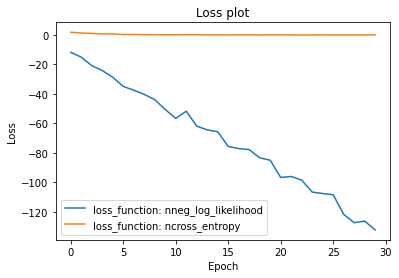

In [18]:
####### plot the the training loss here #########
num_epochs = 30
epochs = [x for x in range(num_epochs)]
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss plot")

for loss_function in hyper_parameters["loss_function"]:
    plt.plot(
        epochs,
        train_loss_hyper_paramaters[f"lf{loss_function}"],
        label=f"loss_function: {loss_function}",
    )

plt.legend()


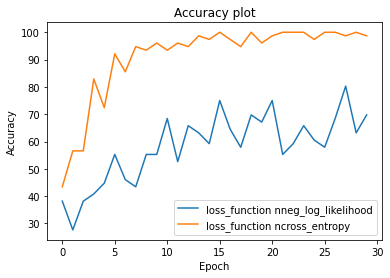

In [19]:
####### plot the the training accuracies here #########

epochs = [x for x in range(num_epochs)]
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")

for loss_function in hyper_parameters["loss_function"]:
    plt.plot(
        epochs,
        train_acc_hyper_paramaters[f"lf{loss_function}"],
        label=f"loss_function {loss_function}",
    )

plt.legend()
